In [69]:
from PIL import Image

from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, fsolve, fmin
from scipy.special import erf

def normal(x, n, sigma, mu):
    return n * np.exp(-(((x - mu) / sigma) ** 2) / 2) / (sigma * sqrt(2 * pi))

def cum_normal(x, n, mu, sigma):
    return n * (1 + erf((x - mu) / (sigma * np.sqrt(2)))) / 2

In [2]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rc('font', size=12)

In [98]:
sigmas = []
bw = []

positions = ["1-13"]
positions.extend(range(13))

for i in range(13):
    img = np.asarray(Image.open(f"lab/images/pos-{i}.tif"))

    a = img[:, :, 0]
    ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

    fig, ax = plt.subplots()
    y = img[:, ind[1], 0]
    x = np.arange(0, 3.571, step=3.571 / y.shape[0])

    ax.plot(x, y, label="pixel")

    (n, sigma, mu) = curve_fit(normal, x, y, p0=(100, 1, 2.25))[0]
    sigmas.append(sigma)
    ax.plot(
        x,
        normal(x, n, sigma, mu),
        label=f"$\mathcal {{N}}(\mu = {mu:.2f} ,\sigma ^{2} = {mu**2:.2f})$",
    )

    maxi = normal(mu, n, sigma, mu)
    # ax.plot(mu, maxi, "o")
    if i == 5:
        x1 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.1)[0]
        x2 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.225)[0]
    elif i == 6:
        x1 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.15)[0]
        x2 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.21)[0]
    elif i == 7:
        x1 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.15)[0]
        x2 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.225)[0]
    else:
        x1 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2)[0]
        x2 = fsolve(lambda x: normal(x, n, sigma, mu) - maxi / exp(2), 2.25)[0]

    bw.append(x2 - x1)
    x = np.linspace(x1, x2)
    ax.plot(x, np.repeat(maxi / exp(2), x.shape[0]), label=f"Diametro ($1/e^2$) = {x2 - x1:.2f}mm")

    plt.legend()
    plt.xlabel("Posición pixel (mm)")
    plt.ylabel("Intensidad capturada por cámara")
    plt.savefig(f"lab/plots/plot-{i}.pdf")
    plt.close()

1.3933521239326219


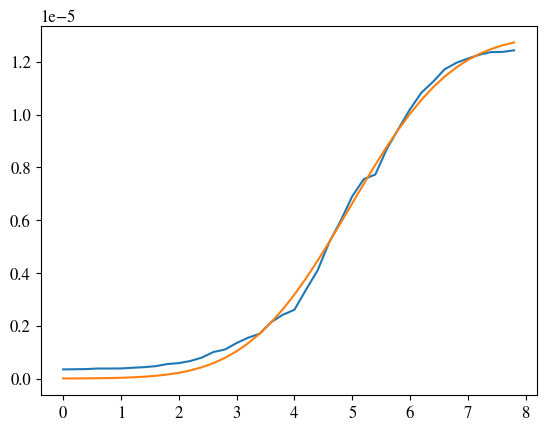

In [156]:
fig, ax = plt.subplots()

y = np.array(
    [
        1.2439e-05,
        1.2379e-05,
        1.2372e-05,
        1.2272e-05,
        1.2128e-05,
        1.1963e-05,
        1.1721e-05,
        1.125e-05,
        1.0841e-05,
        1.0204e-05,
        9.4626e-06,
        8.7057e-06,
        7.7316e-06,
        7.5566e-06,
        6.9018e-06,
        5.9744e-06,
        5.1488e-06,
        4.0933e-06,
        3.3602e-06,
        2.6045e-06,
        2.4165e-06,
        2.1402e-06,
        1.6982e-06,
        1.5468e-06,
        1.3448e-06,
        1.0996e-06,
        1.0048e-06,
        7.9386e-07,
        6.6391e-07,
        5.8455e-07,
        5.4711e-07,
        4.6873e-07,
        4.308e-07,
        4.0828e-07,
        3.821e-07,
        3.7914e-07,
        3.797e-07,
        3.5815e-07,
        3.5089e-07,
        3.4628e-07,
    ]
)[::-1]
x = np.arange(0, y.shape[0] * 0.2, step=0.2)

(n, mu, sigma) = curve_fit(cum_normal, x, y, p0=(0.00013, 20, 10))[0]

ax.plot(x, y)
ax.plot(x, cum_normal(x, n, mu, sigma))

print(sigma)

[8.35446114e+00 2.13011366e-03]


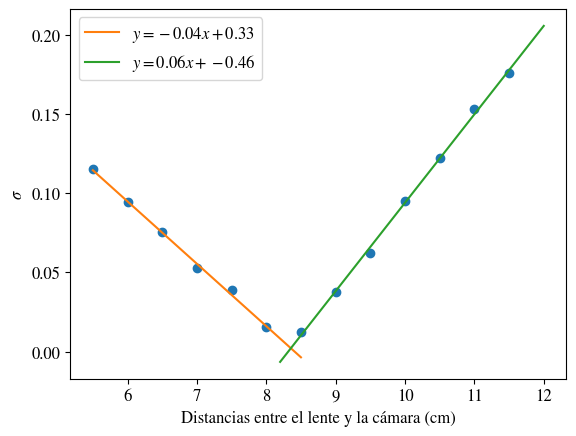

In [4]:
from numpy.polynomial.polynomial import Polynomial


def eval_poly(x, coef):
    result = 0
    for i, c in enumerate(coef):
        result += c * (x**i)

    return result

start = 11.5 - 0.5 * 12
end = 12

fig, ax = plt.subplots()
x = np.arange(start, end, step=0.5)
# x = np.append(x, 22.8)
# x = np.append(x, 27.6)
y = sigmas[::-1][:-1]
# y = np.append(y, sigma)

ax.plot(x, y, "o")

a = []
b = []

spl = 6

poly = Polynomial.fit(x[:spl], y[:spl], 1)
coef = poly.convert().coef

a.append([coef[1], -1])
b.append(-coef[0])

_x = np.linspace(start, 8.5, num=50)
ax.plot(_x, eval_poly(_x, coef), label=f"$y={coef[1]:.2f}x+{coef[0]:.2f}$")

poly = Polynomial.fit(x[spl:], y[spl:], 1)
coef = poly.convert().coef

a.append([coef[1], -1])
b.append(-coef[0])

_x = np.linspace(8.2, end, num=50)
ax.plot(_x, eval_poly(_x, coef), label=f"$y={coef[1]:.2f}x+{coef[0]:.2f}$")

print(np.linalg.solve(a, b))

plt.legend()
plt.xlabel("Distancias entre el lente y la cámara (cm)")
plt.ylabel("$\sigma$")
plt.savefig("lab/plots/focal_point.pdf")

w_0 = 0.0389
z_R = 0.1995


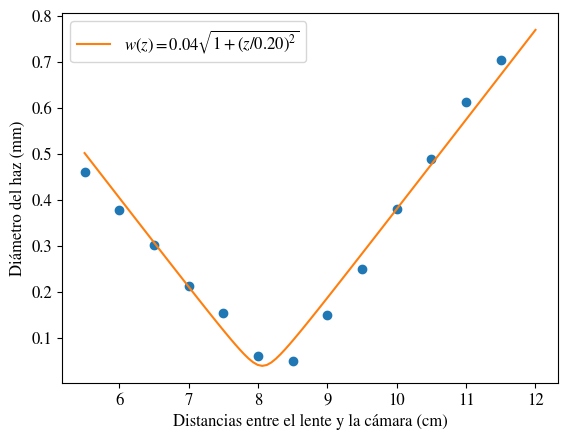

In [106]:
def width(z, w_0, z_r, z_0):
    return w_0 * np.sqrt(1 + ((z - z_0) / z_r) ** 2)


start = 11.5 - 0.5 * 12
end = 12

fig, ax = plt.subplots()
x = np.arange(start, end, step=0.5)
# x = np.append(x, 22.8)
# x = np.append(x, 27.6)
y = np.array(bw)[::-1]
# y = np.append(y, sigma)

(w_0, z_r, z_0) = curve_fit(width, x, y, p0=(0.1, 0.1, 8.5))[0]

ax.plot(x, y, "o")
x = np.linspace(start, end, num=100)
ax.plot(x, width(x, w_0, z_r, z_0), label=f"$w(z)={w_0:.2f}\sqrt{{1+(z/{z_r:.2f})^2}}$")
# ax.plot(x, width(x, 0.1, 0.05, 8.5))

plt.legend()
plt.xlabel("Distancias entre el lente y la cámara (cm)")
plt.ylabel("Diámetro del haz (mm)")
plt.savefig("lab/plots/focal_point.pdf")

print(f"w_0 = {w_0:.4f}")
print(f"z_R = {z_r:.4f}")

In [44]:
fmin(lambda x: width(x, w_0, z_r, z_0), x0=[8])

Optimization terminated successfully.
         Current function value: 0.009729
         Iterations: 13
         Function evaluations: 26


array([8.06259766])

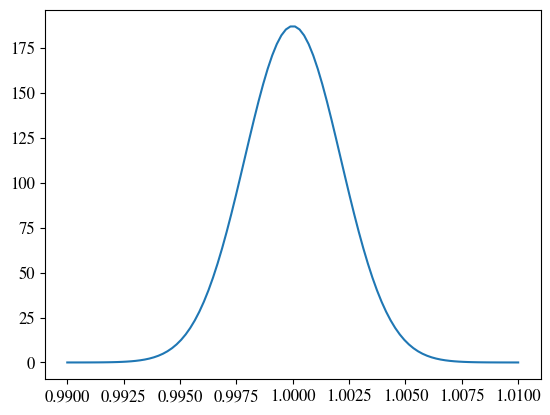

0.9975 1.0025 0.004999999999999893


/tmp/ipykernel_455194/177836798.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x1 = fsolve(lambda x: normal(x, 1, sigma, 1) - (maxi / 2), 0.9975)[0]
/tmp/ipykernel_455194/177836798.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x2 = fsolve(lambda x: normal(x, 1, sigma, 1) - (maxi / 2), 1.0025)[0]


In [9]:
fig, ax = plt.subplots()

sig_0 = 2.13011366e-03
maxi = normal(1, 1, sig_0, 1)
x = np.linspace(0.99, 1.01, num=100)
y = normal(x, 1, sig_0, 1)
ax.plot(x, y)
plt.show()

x1 = fsolve(lambda x: normal(x, 1, sigma, 1) - (maxi / 2), 0.9975)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, 1) - (maxi / 2), 1.0025)[0]
print(x1, x2, x2 - x1)

Sigma: 45.75000789867486
Mu: 392.0660907863463
FWHM: 107.74126860137929
Beam diameter (FWHM): 0.5009688413743821 mm
Beam diameter (1/e^2): 0.8509024906571245 mm


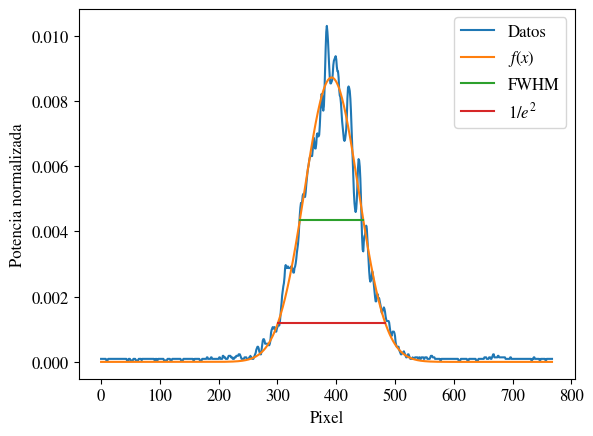

In [76]:
img = np.asarray(Image.open("lab/images/LaserCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
ax.set_xlabel("Pixel")
ax.set_ylabel("Potencia normalizada")

y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y / n, label="Datos")
ax.plot(x, normal(x, 1, sigma, mu), label=r"$f(x)$")

maxi = normal(mu, 1, sigma, mu)

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 450)[0]
x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / 2, x.shape[0]), label="FWHM")

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 500)[0]

x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / exp(2), x.shape[0]), label="$1/e^2$")
ax.legend()

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Beam diameter (FWHM): {(3.571 / y.shape[0]) * 2.355 * sigma} mm")
print(f"Beam diameter (1/e^2): {(3.571 / y.shape[0]) * (x2 - x1)} mm")

plt.savefig("lab/plots/plot-LaserCintura.pdf")

Sigma: 97.79557969732285
Mu: 375.89435794625075
FWHM: 230.3085901871953
Beam diameter (FWHM): 1.070874968175097 mm
Beam diameter (1/e^2): 1.8188959119746864 mm


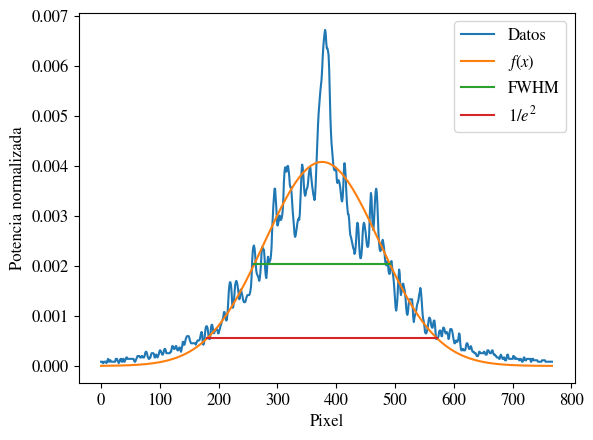

In [75]:
img = np.asarray(Image.open(f"lab/images/FibraCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
ax.set_xlabel("Pixel")
ax.set_ylabel("Potencia normalizada")

y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y / n, label="Datos")
ax.plot(x, normal(x, 1, sigma, mu), label=r"$f(x)$")

maxi = normal(mu, 1, sigma, mu)

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 450)[0]
x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / 2, x.shape[0]), label="FWHM")

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 500)[0]

x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / exp(2), x.shape[0]), label="$1/e^2$")
ax.legend()

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Beam diameter (FWHM): {(3.571 / y.shape[0]) * 2.355 * sigma} mm")
print(f"Beam diameter (1/e^2): {(3.571 / y.shape[0]) * (x2 - x1)} mm")

plt.savefig("lab/plots/plot-FibraCintura.pdf")